In [1]:
import os
from pathlib import Path
import numpy as np
import allego_file_reader as afr # make sure there's a allego_file_reader.py
import pandas as pd
import matplotlib.pyplot as plt
import cv2 # opencv-python

In [2]:
LED_threshhold = 100 # >100: light on
analog_threshhold = 0.1 # for analog input, signal high usually around 0.13, signal low around 0.04
frame_rate = 100 # video frame rate 
sample_rate = 30000 # assumed ephys recording sample rate, will calculate a true sample rate later

In [3]:
ephys_dir = "ephys" # directory that have 3 ephys raw data: .xdat, .json, timestamp.xdat
video_path = "video/20240315_R19_stim_anes_008_R_fullres_12-04-07.avi" # video file

left, top, right, bottom = 877, 22, 897, 42# Setting the points for cropped image - Right camera

# Read Ephys raw data- analog input

In raw .xdat data, there are 39 channels: recording channel 1~32, then AI1, AI2, DI1, DI2, STIM, DO1, DO2

eg. recordnig channel 15 is channel[14], AI1 is channel[32], STIM is channel[36]

In [4]:
# Read .xdat file

time_start = None
time_end = None

p = Path(ephys_dir).expanduser()
all_xdat_datasource_names = [Path(elem.stem).stem for elem in list(p.glob('**/*xdat.json'))]
all_xdat_datasource_names[0]

target_file = str(Path(ephys_dir, all_xdat_datasource_names[0]))

time_range = afr.get_allego_xdat_time_range(target_file)

metadata = afr.read_allego_xdat_metadata(target_file)

channel, timestamps, time_samples = afr.read_allego_xdat_all_signals(target_file, 
                                                                          time_start, time_end)

# there are 39 channels: recording channel 1~32, then AI1, AI2, DI1, DI2, STIM, DO1, DO2
# eg. recordnig channel 15 is channel[14], AI1 is channel[32], STIM is channel[36]

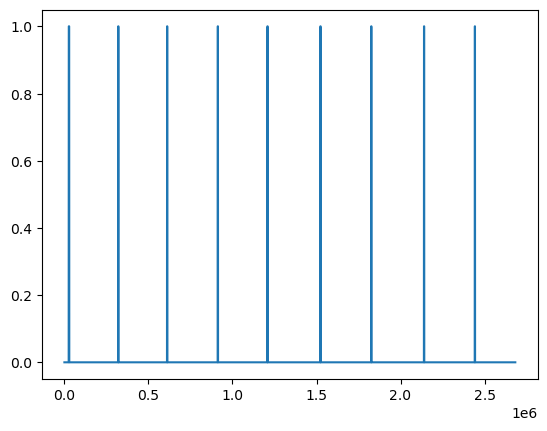

In [5]:
# read analog input from channel[32], and convert it to binary
analog_time = np.where(channel[32] > analog_threshhold, 1, 0)
plt.plot(analog_time)

In [6]:
# Downsampling analog input for cross correlation
analog_time_down = analog_time[::int(sample_rate / frame_rate)]

In [7]:
# calculate  the time point(as ephys sample) when a signal start

analog_time_point = [] 

for index in range(0,len(timestamps)-1):
    if (analog_time[index+1] - analog_time[index] > 0):
        analog_time_point.append(index)

print(analog_time_point)

[25550, 319723, 610402, 911864, 1207482, 1522527, 1824892, 2138943, 2441308]


# Read LED signal from video

In [8]:
video = cv2.VideoCapture(video_path)
brightness = []

while (video.isOpened()):
    ret, frame = video.read()
    if not ret:
        break
    frame_8bit = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY) # convert RGB to 8-bit
    cropped_frame = frame_8bit[top:bottom,left:right] # Crop the frame for only a small area of LED
    brightness.append(cv2.mean(cropped_frame)[0]) # Calculate brightness of the cropped frame (average pixel intensity)
video.release()

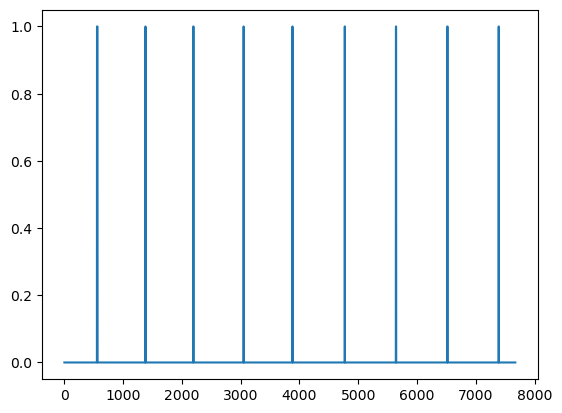

In [9]:
LED_time = np.where(np.array(brightness) > LED_threshhold, 1, 0)
plt.plot(LED_time)

In [10]:
# calculate the time point(as frame) when light start

LED_time_point = [] 

for index in range(0,len(LED_time)-1):
    if (LED_time[index+1] - LED_time[index] > 0):
        LED_time_point.append(index)
        
print(LED_time_point)

[553, 1377, 2191, 3047, 3877, 4768, 5639, 6513, 7387]


In [11]:
# # Get LED_time by reading a csv file got from Fiji, will change to input raw video and calculate in this script later
# LED = pd.read_csv('video/LED.CSV') 
# LED.rename(columns={'Slice':'Frame','Mean':'LED_Signal'},inplace = True)
# LED['LED_Signal'] = LED['LED_Signal'].apply(modify_LED_to_binary)
# LED_time = np.array(LED['LED_Signal'])
# plt.plot(LED_time)

# Match video and ephys by calculating lag_time

Two time series for this purpose: LED_time & analog_time_down (if upsampling LED_time, it seems to take too long to run)

In [12]:
# Preprocessing: pad the shorter time series with zeros to match the length of the longer time series

max_length = max(len(LED_time), len(analog_time_down))
LED_time_padded = np.pad(LED_time, (0, max_length - len(LED_time)))
analog_time_padded = np.pad(analog_time_down, (0, max_length - len(analog_time_down)))


lag_time is the the time that video ahead of ephys

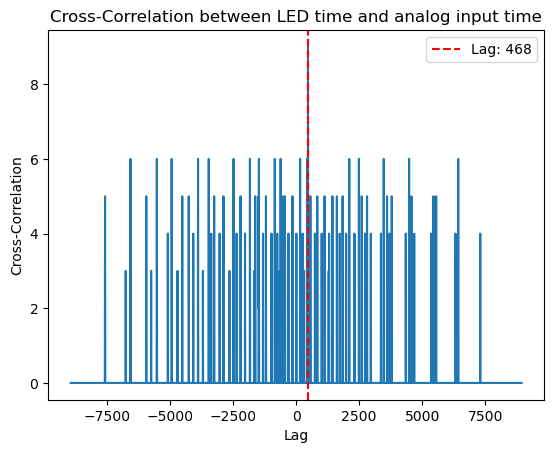

Lag frame: 468
4.68


In [13]:
# Compute cross-correlation
cross_corr = np.correlate(LED_time_padded, analog_time_padded, mode='full')

# Find the lag time corresponding to the maximum correlation
lag_frame = np.argmax(cross_corr) - max_length + 1

# Plot the cross-correlation
plt.plot(np.arange(-max_length + 1, max_length), cross_corr)
plt.xlabel('Lag')
plt.ylabel('Cross-Correlation')
plt.title('Cross-Correlation between LED time and analog input time')
plt.axvline(x=lag_frame, color='r', linestyle='--', label=f'Lag: {lag_frame}')
plt.legend()
plt.show()

print("Lag frame:", lag_frame)

lag_time = float(lag_frame / frame_rate)
print(lag_time) # unit:second

# Verify the result

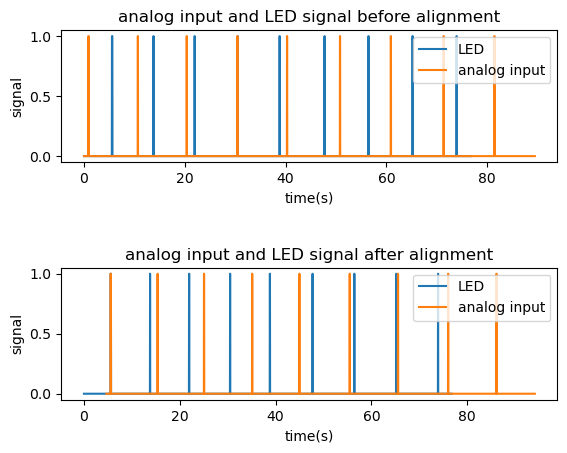

In [14]:
# analog input and LED signal before alignment

LED_time_intervals = [i / frame_rate for i in range(0, len(LED_time))]
analog_time_intervals = [i / sample_rate for i in range(0, len(analog_time))]

plt.subplot(2, 1, 1)
plt.plot(LED_time_intervals,LED_time,label="LED")
plt.plot(analog_time_intervals,analog_time,label="analog input")
plt.xlabel('time(s)')
plt.ylabel('signal')
plt.title('analog input and LED signal before alignment')
plt.legend()

# analog input and LED signal after alignment
modified_analog_time_intervals = [i / sample_rate + lag_time for i in range(0, len(analog_time))]

plt.subplot(2, 1, 2)
plt.plot(LED_time_intervals,LED_time,label="LED")
plt.plot(modified_analog_time_intervals,analog_time,label="analog input")
plt.xlabel('time(s)')
plt.ylabel('signal')
plt.title('analog input and LED signal after alignment')

plt.subplots_adjust(hspace=0.8)
plt.legend()
plt.show()


slope:  -0.15152027622924735
lag_time:  4.703851035500199


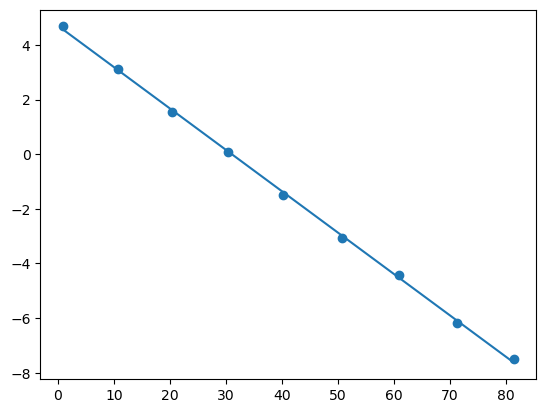

In [15]:
# plot time difference between LED & analog in to get an accurate lag_time

# delete extra LED or analog in signal that start earlier when the other recording is not start yet. To match the first signal of both
if (lag_time > 0): # video starts first
    LED_time_point_aligned = [i for i in LED_time_point if i >= lag_time * frame_rate ]
    analog_time_point_aligned = analog_time_point
else: # ephys starts first
    LED_time_point_aligned = LED_time_point
    analog_time_point_aligned = [i for i in analog_time_point if i >= (-lag_time * sample_rate) ]   

time_diff = [] # difference in time point(s) of LED and analog in when signal-on, as y
time = [] # the time point(doesn't matter from LED or analog in), as x
for index in range(0,min(len(LED_time_point_aligned),len(analog_time_point_aligned))):
    time_diff.append( LED_time_point_aligned[index]/frame_rate - analog_time_point_aligned[index]/sample_rate)
    time.append(analog_time_point_aligned[index]/sample_rate)

# plot time-time_diff between each signal, calculate coefficients in y=ax+b, b equal the lag time(more accurate than before), a closer to zero means less mistake stretch in two timeline
coefficients = np.polyfit(time, time_diff, deg=1)
time_diff_fitted = np.polyval(coefficients, time)

plt.scatter(time,time_diff)
plt.plot(time,time_diff_fitted)

slope_of_time_diff,lag_time = coefficients

np.set_printoptions(suppress=True)
print("slope: ",slope_of_time_diff)
print("lag_time: ", lag_time)

# Calculate true ephys sample rate

In [19]:
# the difference between  time gap in LED and analog is caused by a small stretch because of inaccurate sample rate
# calculate the ratio between two to calibrate ephys sample rate
LED_time_gap = []  # the time gap(as frame) between to light-start time point
analog_time_gap = [] # the time gap(as ephys sample) between to sigal-on time point
for index in range(0,min(len(LED_time_point_aligned),len(analog_time_point_aligned))-1):
    LED_time_gap.append((LED_time_point_aligned[index+1] - LED_time_point_aligned[index]) / frame_rate)
    analog_time_gap.append((analog_time_point_aligned[index+1] - analog_time_point_aligned[index]) / sample_rate)

gap_ratio = [] # the ratio
for index in range(0,min(len(LED_time_point_aligned),len(analog_time_point_aligned))-1):
    gap_ratio.append(analog_time_gap[index] / LED_time_gap[index])
                   
true_sample_rate = sample_rate *  np.mean(gap_ratio)
print(LED_time_gap)
print(analog_time_gap)
print(true_sample_rate)

[8.24, 8.14, 8.56, 8.3, 8.91, 8.71, 8.74, 8.74]
[9.805766666666667, 9.6893, 10.048733333333333, 9.853933333333334, 10.5015, 10.078833333333334, 10.468366666666666, 10.078833333333334]
35355.766948782715


# Rerun with true_sample_rate

Verify again

slope:  -0.0000449542
lag_time:  4.7038510355001995


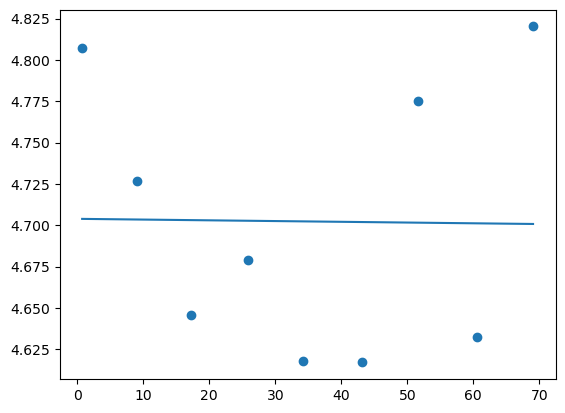

In [17]:
# plot time difference between LED & analog in to get an accurate lag_time

time_diff_rerun = [] # difference in time point(s) of LED and analog in when signal-on, as y
time_rerun = [] # the time point(doesn't matter from LED or analog in), as x
for index in range(0,min(len(LED_time_point_aligned),len(analog_time_point_aligned))):
    time_diff_rerun.append( LED_time_point_aligned[index]/frame_rate - analog_time_point_aligned[index]/true_sample_rate)
    time_rerun.append(analog_time_point_aligned[index]/true_sample_rate)

# plot time-time_diff between each signal, calculate coefficients in y=ax+b, b equal the lag time(more accurate than before), a closer to zero means less mistake stretch in two timeline
coefficients_rerun = np.polyfit(time_rerun, time_diff_rerun, deg=1)
time_diff_fitted_rerun = np.polyval(coefficients_rerun, time_rerun)

plt.scatter(time_rerun,time_diff_rerun)
plt.plot(time_rerun,time_diff_fitted_rerun)

slope_of_time_diff_rerun,lag_time_rerun = coefficients_rerun

np.set_printoptions(suppress=True)
print("slope: ","{:.10f}".format(slope_of_time_diff_rerun))
print("lag_time: ", lag_time_rerun)

In [18]:
print("ephys true sample rate: ","{:.4f}".format(true_sample_rate))
print("lag_time between video and ephy: ","{:.4f}".format(lag_time))

ephys true sample rate:  35355.7669
lag_time between video and ephy:  4.7039


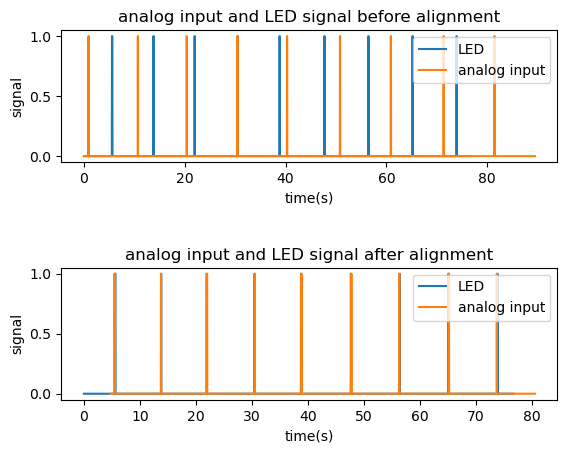

In [20]:
# analog input and LED signal before alignment

LED_time_intervals = [i / frame_rate for i in range(0, len(LED_time))]
analog_time_intervals = [i / sample_rate for i in range(0, len(analog_time))]

plt.subplot(2, 1, 1)
plt.plot(LED_time_intervals,LED_time,label="LED")
plt.plot(analog_time_intervals,analog_time,label="analog input")
plt.xlabel('time(s)')
plt.ylabel('signal')
plt.title('analog input and LED signal before alignment')
plt.legend()

# analog input and LED signal after alignment
modified_analog_time_intervals = [i / true_sample_rate + lag_time for i in range(0, len(analog_time))]

plt.subplot(2, 1, 2)
plt.plot(LED_time_intervals,LED_time,label="LED")
plt.plot(modified_analog_time_intervals,analog_time,label="analog input")
plt.xlabel('time(s)')
plt.ylabel('signal')
plt.title('analog input and LED signal after alignment')

plt.subplots_adjust(hspace=0.8)
plt.legend()
plt.show()